In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs

import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
from amftrack.pipeline.functions.transport_processing.high_mag_videos.loading import load_video_dataset_local
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
from amftrack.pipeline.functions.transport_processing.high_mag_videos.register_videos import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\graphs"
plates = [
    "441_20230807", "449_20230807", "310_20230830"
]
plate_id = plates[0]
path_tot = os.path.join(path_root,f"graph{plate_id}.pickle")
spatial_temporal_graph,folders = load(path_tot)
transforms = spatial_temporal_graph.transforms

In [16]:

path_tot = os.path.join(path_root,f"graph{plate_id}_flux.pickle")
spatial_temporal_graph,folders = load(path_tot)
spatial_temporal_graph.transforms = transforms

In [17]:
exp = make_exp(spatial_temporal_graph,folders)

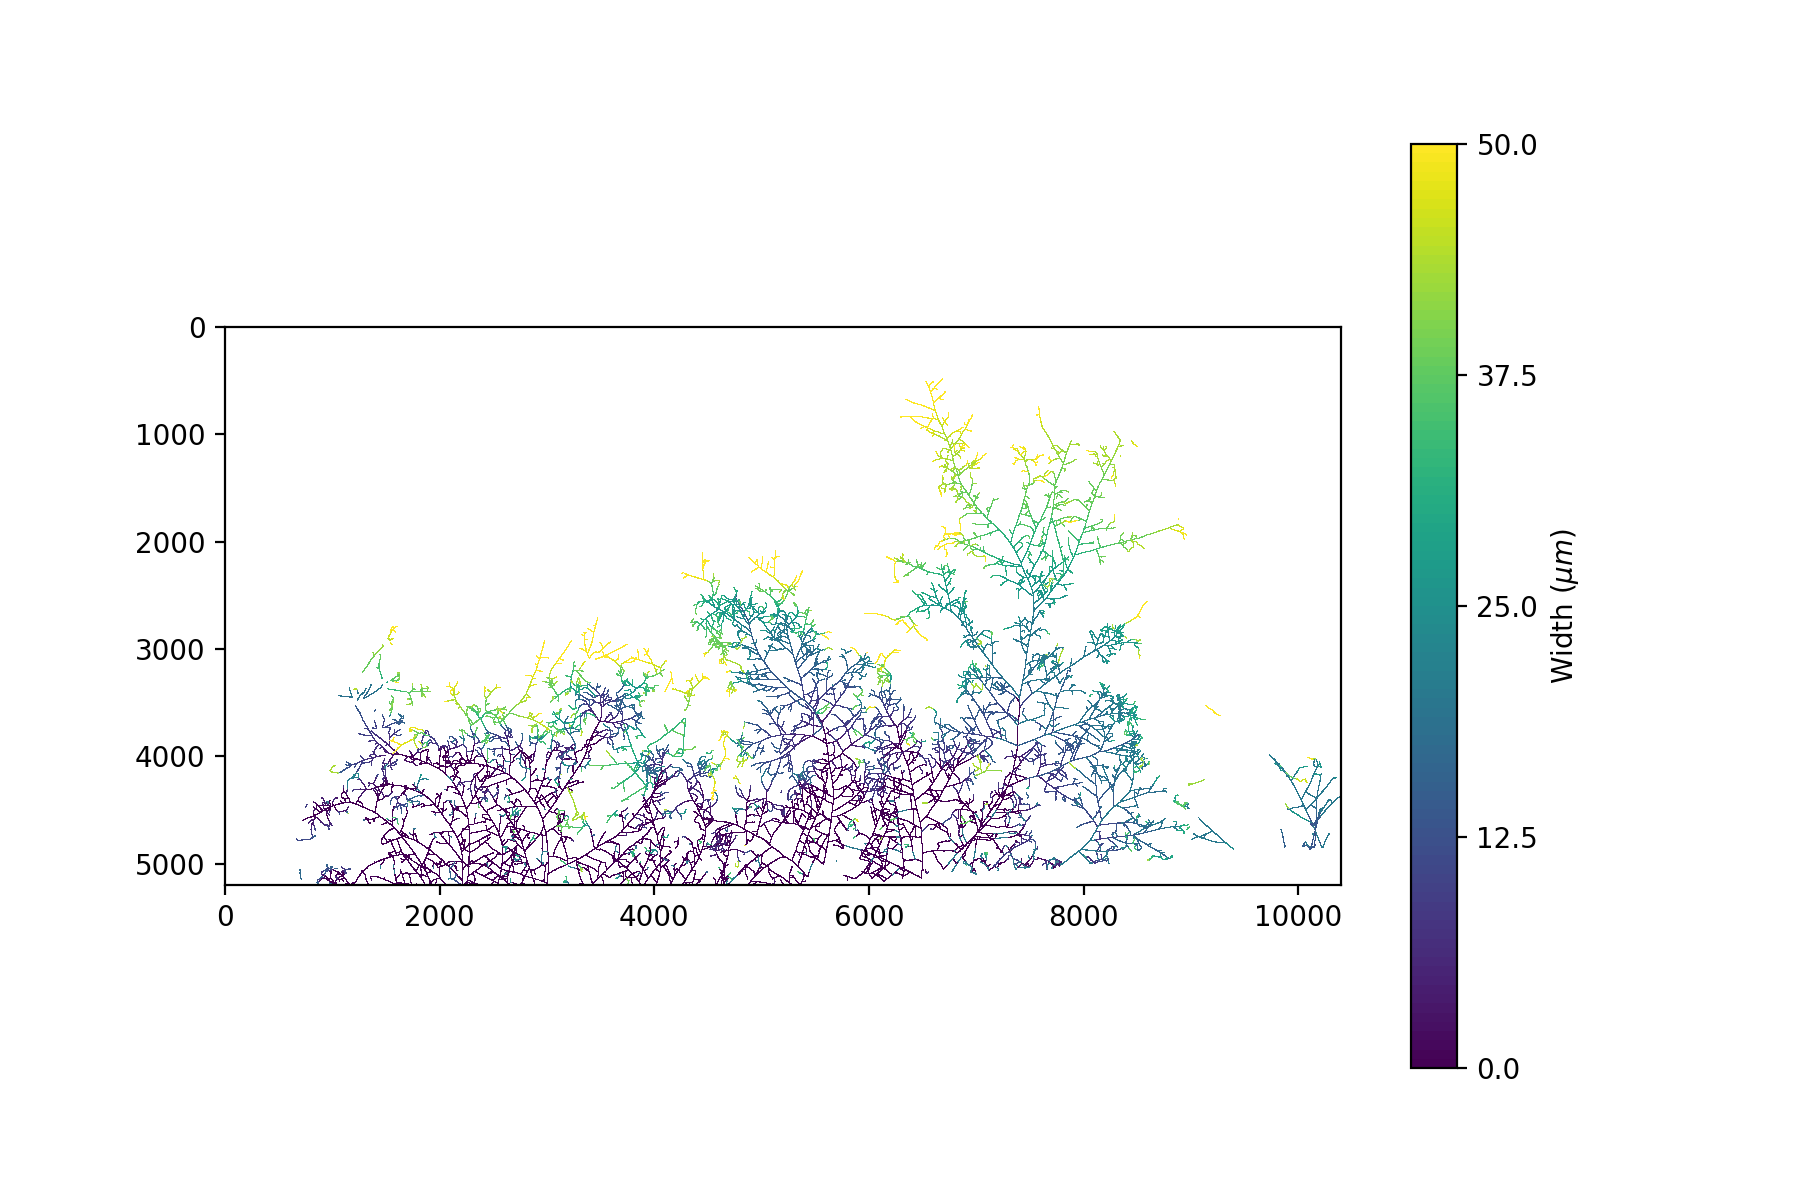

(<Figure size 1800x1200 with 2 Axes>, <AxesSubplot: >)

In [18]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 50
vmin = 0
t=0
region = [[3750*5,4500*5],[5250*5,8000*5]]
region = [[0*5,0*5],[26000,52000]]

fig,ax = plt.subplots(figsize=(9, 6))
plot_edge_color_value(
    exp,
    t,
    lambda edge : edge.get_attribute("post_hyperedge_activation",t),
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    alpha = 1,
    figax = (fig,ax),
    region = region
)


In [19]:
analysis_folder = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract"
analysis_folder_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract/"
videos_folder = "/projects/0/einf914/videos/"


In [20]:
refs = {
    "310_20230830": {
        "20230901_Plate310": "20230901_0719_Plate06",
        "20230902_Plate310": "20230902_1343_Plate07",
        "20230903_Plate310": "20230903_1143_Plate07",
        "20230904_Plate310": "20230904_0942_Plate07",
        "20230905_Plate310": "20230905_1345_Plate07",
        # "20230906_Plate310" : "20230906_1220_Plate07",
    },
    "441_20230807": {
        "20230810_Plate441": "20230810_1005_Plate14",
        "20230811_Plate441": "20230811_1605_Plate14",
        "20230812_Plate441": "20230812_1006_Plate14",
        # "20230813_Plate441": "20230813_1618_Plate14",
    },
    "449_20230807": {
        "20230813_Plate449": "20230813_1606_Plate10",
        "20230814_Plate449": "20230814_1019_Plate10",
        "20230815_Plate449": "20230815_1021_Plate10",
        # "20230816_Plate449": "20230816_1027_Plate10",
        # "20230818_Plate449": "20230818_1107_Plate10",
    },
}

In [21]:
indexes = refs[plate_id]

In [22]:
def get_transform(spatial_temporal_graph,i):
    transforms = spatial_temporal_graph.transforms
    Rs = [transform[0] for transform in transforms]
    ts = [transform[1] for transform in transforms]
    R0 = Rs[i]
    t0 = ts[i]
#     R0 = np.array([[1, 0], [0, 1]])
#     t0 = np.array([[0, 0]])

#     for k in range(i):
#         index = i - 1 - k
#         R0 = np.dot(Rs[index], R0)
#         t0 = (Rs[index] @ ts[index].transpose()).transpose() + (Rs[index] @ t0.transpose()).transpose()
    return(R0,t0)

In [23]:
for plate_id_video in list(indexes.keys())[0:]:
    i = np.where(folders["folder"] == indexes[plate_id_video])[0][0]
    
    G = create_subgraph_by_attribute(spatial_temporal_graph, "post_hyperedge_activation", i)
    exp0 = make_exp(G,folders,make_pixel_list = True,spacing = 1)
    print(plate_id_video)
    data_obj = load_video_dataset_local(plate_id_video, videos_folder, analysis_folder, analysis_folder_root,"_network")
    data_obj.video_objs = sorted(data_obj.video_objs, key=lambda video: video.dataset["video_int"])
    R0,t0 = get_transform(spatial_temporal_graph,i)
    t0 = t0.flatten()
    for vid_obj in data_obj.video_objs:
        if vid_obj.dataset["magnification"] == 50 and len(vid_obj.edge_objs)>0:
            # vid_obj.plot_speed_arrows(plot_both=True, video_txt_size=30)     

            Rcurrent, tcurrent, mapping, dist = process_video_object_new(
                vid_obj, exp0, 0, R0, t0
            )
            print(vid_obj.dataset['video_int'],dist)
            for edge_obj in vid_obj.edge_objs:
                if edge_obj.edge_name in mapping.keys():
                    (x1,y1) = edge_obj.mean_data["edge_xpos_1"],edge_obj.mean_data["edge_ypos_1"]
                    (x2,y2) = edge_obj.mean_data["edge_xpos_2"],edge_obj.mean_data["edge_ypos_2"]
                    (x1,_) = Rcurrent@(x1,y1)
                    (x2,_) = Rcurrent@(x2,y2)                    
                    
                    edge_network = mapping[edge_obj.edge_name]
                    (u,v) = (edge_network.begin.label,edge_network.end.label)
                    index = indexes[plate_id_video]  
                    timeste_graph_attributes = spatial_temporal_graph[u][v][str(i)]
                    if not 'video_edge' in timeste_graph_attributes:
                        timeste_graph_attributes['video_edge'] = []
                        timeste_graph_attributes['folder'] = []
                        timeste_graph_attributes['ordered_mapping'] = []
                        timeste_graph_attributes['mapping'] = []
                        timeste_graph_attributes['R'] = []
                    timeste_graph_attributes['video_edge'].append(edge_obj)
                    timeste_graph_attributes['folder'].append(index)
                    timeste_graph_attributes['ordered_mapping'].append(2*(x1>x2)-1)
                    timeste_graph_attributes['mapping'].append(dist)   
                    timeste_graph_attributes['R'].append(Rcurrent)
                    # timeste_graph_attributes['QBC_tot']
            # break
    # break
                
    # break
    

20230810_Plate441
Couldn't find the edges data file at C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract\20230810_Plate441\029\Img\edges_data.csv. Check analysis for 20230810_Plate441_029
Couldn't find the edges data file at C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract\20230810_Plate441\047\Img\edges_data.csv. Check analysis for 20230810_Plate441_047
Couldn't find the edges data file at C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract\20230810_Plate441\053\Img\edges_data.csv. Check analysis for 20230810_Plate441_053
Couldn't find the edges data file at C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract\20230810_Plate441\097\Img\edges_data.csv. Check analysis for 20230810_Plate441_097
Couldn't find the edges data file at C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract\20230810_Plate441\102\Img\edges_data.csv. Check analysis for 20230810_Plate441_102
5 -1
6 -1
7 1.331

In [24]:
mapping

{'(39, 0)': Edge(15656,13287),
 '(40, 3)': Edge(14973,15656),
 '(41, 40)': Edge(15656,16862),
 '(39, 4)': Edge(15656,15227)}

In [25]:
def check_has_video(edge,graph):
    for i in range(graph.max_age+1):
        if 'video_edge' in graph[edge[0]][edge[1]][str(i)]:
            return(True)
    return(False)
edges_info = [edge for edge in spatial_temporal_graph.edges() if check_has_video(edge,spatial_temporal_graph)]
iss = []

for edge in edges_info:
    for i in range(spatial_temporal_graph.max_age+1):
         if 'video_edge' in spatial_temporal_graph[edge[0]][edge[1]][str(i)]:
            if i not in iss:
                iss.append(i)
                print(i,spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'])

25 [<amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis.EdgeDataset object at 0x000001B7BC97BE80>, <amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis.EdgeDataset object at 0x000001B7BC97BF70>, <amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis.EdgeDataset object at 0x000001B7BC978880>, <amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis.EdgeDataset object at 0x000001B7BC97ABF0>, <amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis.EdgeDataset object at 0x000001B7BC97B430>, <amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis.EdgeDataset object at 0x000001B7BC9EAEF0>, <amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis.EdgeDataset object at 0x000001B7BC9E89A0>, <amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis.EdgeDataset object at 0

In [26]:
spatial_temporal_graph.folder_infos = [folders.transpose()]

In [27]:
path_tot = os.path.join(path_root,f"graph{plate_id}_video.pickle")

pickle.dump(spatial_temporal_graph, open(path_tot, 'wb'))

In [54]:
spatial_temporal_graph[u][v][str(i)]

{'width': 7.894738479539033,
 'QBC_net': 0,
 'QBC_tot': 0,
 'speed_backflow': -0.0025501914713459105,
 'water_flux': -0.0624177588599249,
 'speed_heaton': 0.05343748572274479,
 'water_flux_heaton': 2.615841308701907,
 'water_flux2': 8.05627474416625}

In [12]:
R0,t0 = get_transform(spatial_temporal_graph,i)
t0 = t0.flatten()
Rcurrent, tcurrent, mapping, dist = process_video_object_new(
    vid_obj, exp0, 0, R0, t0
)
for edge_obj in vid_obj.edge_objs:
    edge_network = mapping[edge_obj.edge_name]
    (u,v) = (edge_network.begin.label,edge_network.end.label)
    index = indexes[plate_id_video]  
    spatial_temporal_graph_simple[u][v]['video_edge'][index] = edge_obj
    spatial_temporal_graph_simple[u][v]['mapping'][index] = dist    

NameError: name 'spatial_temporal_graph_simple' is not defined

C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract\20230814_Plate449\017\Img\20230814_Plate449_017_video.mp4


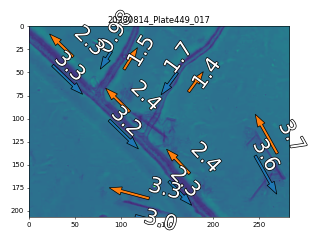

In [90]:
mpl.rcParams["figure.dpi"] = 50

vid_obj = data_obj.video_objs[16]

vid_obj.plot_speed_arrows(plot_both=True, video_txt_size=30)

In [80]:
vid_obj.dataset['video_int']

27

In [136]:
# Rcurrent, tcurrent = spatial_temporal_graph.transforms[i]
# Rcurrent, tcurrent = np.array([[1, 0], [0, 1]]), np.array([0, 0])
R0,t0 = get_transform(spatial_temporal_graph,i)

# Rcurrent, tcurrent = R0,t0
tcurrent = tcurrent.flatten()
positions = (
    Rcurrent @ np.array(vid_obj.dataset[["xpos_network", "ypos_network"]]) + tcurrent
)
positions = positions.flatten()
positions_list = [positions.tolist()]
thresh2 = 100
window = np.array([thresh2, thresh2])
begin = (positions - window).astype(int)
end = (positions + window).astype(int)
region = [[begin[0], begin[1]], [end[0], end[1]]]
shiftx = vid_obj.img_dim[0] * vid_obj.space_res / 1.725 / 2
shifty = vid_obj.img_dim[1] * vid_obj.space_res / 1.725 / 2
segments = get_segments_ends(vid_obj, shiftx, shifty, 30, Rcurrent, tcurrent)
edges = get_all_edges(exp0, t)
edges = [edge for edge in edges if dist_edge(edge, positions, t) <= thresh2]
pixels = [pixel for edge in edges for pixel in edge.pixel_list(t)]
pixels = [pixel for pixel in pixels if np.linalg.norm(pixel - positions) <= thresh2*1.5]

segment_points = []
for begin, end in segments:
    # Include the start point, interpolated points, and the end point
    interpolated_points = interpolate_points(begin, end)
    segment_points.extend(interpolated_points)
    segment_points.append(end)  # Ensure the end point is included

segment_points = np.array(segment_points)

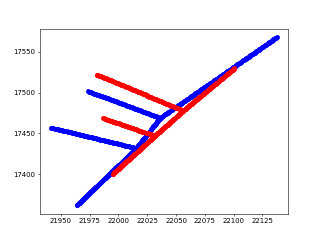

In [137]:
fig, ax = plt.subplots()

# Plotting point cloud
px, py = zip(*pixels)  # Unpacking points into x and y coordinates
ax.scatter(px, py, color="blue")  # Plot points in blue
px, py = zip(*segment_points)  # Unpacking points into x and y coordinates
ax.scatter(px, py, color="red")  # Plot points in blue

In [135]:
t = 0
Rcurrent, tcurrent, mapping, dist = process_video_object_new(
    vid_obj, exp0, t, R0, t0.flatten(),thresh = 20
)

7


In [51]:
dist

214.94074938507822

In [237]:
for edge_obj in vid_obj.edge_objs:
    edge_network = mapping[edge_obj.edge_name]
    (u,v) = (edge_network.begin.label,edge_network.end.label)
    index = indexes[plate_id_video]  
    spatial_temporal_graph_simple[u][v]['video_edge'][index] = edge_obj

In [230]:
spatial_temporal_graph_simple

Edge(18913,19377)

In [238]:
path_tot = os.path.join(path_root,f"graph{plate_id}_video.pickle")

pickle.dump(spatial_temporal_graph, open(path_tot, 'wb'))

In [37]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.register_videos import *
# Rcurrent, tcurrent = spatial_temporal_graph.transforms[i]
# Rcurrent, tcurrent = np.array([[1, 0], [0, 1]]), np.array([0, 0])
tcurrent = tcurrent.flatten()
positions = (
    Rcurrent @ np.array(vid_obj.dataset[["xpos_network", "ypos_network"]]) + tcurrent
)
positions = positions.flatten()
positions_list = [positions.tolist()]
thresh2 = 100
window = np.array([thresh2, thresh2])
begin = (positions - window).astype(int)
end = (positions + window).astype(int)
region = [[begin[0], begin[1]], [end[0], end[1]]]
shiftx = vid_obj.img_dim[0] * vid_obj.space_res / 1.725 / 2
shifty = vid_obj.img_dim[1] * vid_obj.space_res / 1.725 / 2
segments = get_segments_ends(vid_obj, shiftx, shifty, 20, Rcurrent, tcurrent)
edges = get_all_edges(exp0, t)

edges = [edge for edge in edges if dist_edge(edge, positions, t) <= thresh2]
pixels = [pixel for edge in edges for pixel in edge.pixel_list(t)]
pixels = [pixel for pixel in pixels if np.linalg.norm(pixel - positions) <= thresh2*1.5]
segment_points = []
for begin, end in segments:
    # Include the start point, interpolated points, and the end point
    interpolated_points = interpolate_points(begin, end)
    segment_points.extend(interpolated_points)
    segment_points.append(end)  # Ensure the end point is included

segment_points = np.array(segment_points)

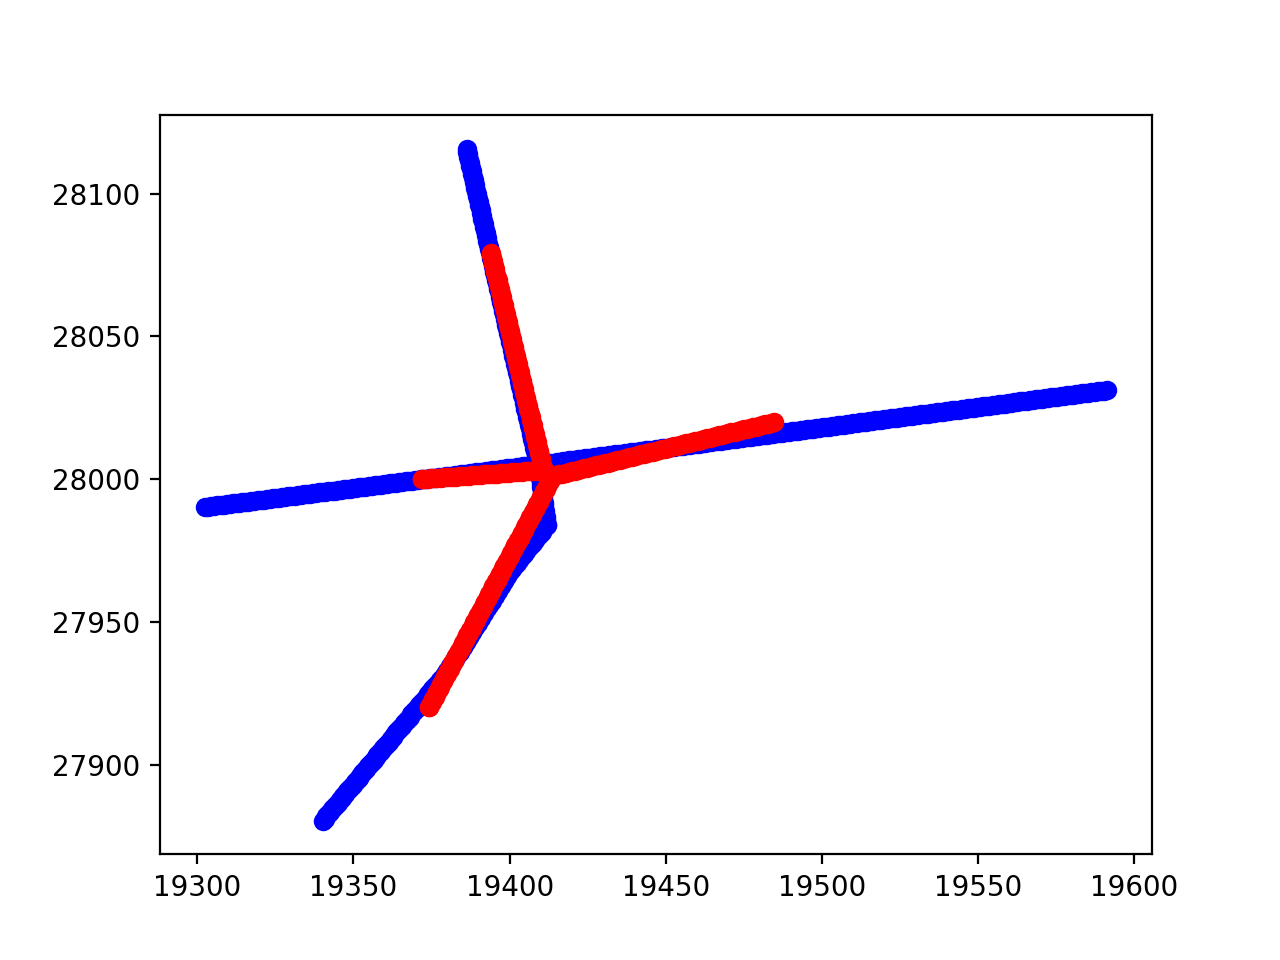

In [38]:
fig, ax = plt.subplots()

# Plotting point cloud
px, py = zip(*pixels)  # Unpacking points into x and y coordinates
ax.scatter(px, py, color="blue")  # Plot points in blue
px, py = zip(*segment_points)  # Unpacking points into x and y coordinates
ax.scatter(px, py, color="red")  # Plot points in blue